## JHU channel flow

### Created by Yuying Liu, 12/03/2019

In [5]:
# imports
import os
import cv2
import sys
import torch
import pickle
# import pyJHTDB
import zeep
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib notebook

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

In [6]:
if os.path.exists('data/channel_flow2.npy'):
    print('it exists')
    data = np.load('data/channel_flow2.npy')
else:
    client = zeep.Client('http://turbulence.pha.jhu.edu/service/turbulence.asmx?WSDL')
    # load shared library
    # lTDB = pyJHTDB.libJHTDB()
    #initialize webservices
    # lTDB.initialize()

    # add token
    auth_token  = "edu.uw.yliu814-dff25860"  # get ur own token from: http://turbulence.pha.jhu.edu/authtoken.aspx
    lTDB.add_token(auth_token)
    
    # info
    n = 3
    info = pyJHTDB.dbinfo.channel
    name = info['name']
    x_sample_factor = 4
    y_sample_factor = 4
    nx = info['nx'] // x_sample_factor
    ny = info['ny'] // y_sample_factor
    xnodes = info['xnodes'][::x_sample_factor]
    ynodes = info['ynodes'][::y_sample_factor]
    zmid = 1.5*np.pi
    
    lpoints = []
    for i in range(nx):
        for j in range(ny):
            lpoints.append([xnodes[i], ynodes[j], zmid])
            
    points = np.array(lpoints, dtype='float32')
    
    data = []
    for t in info['time'][::8]:
        sample = lTDB.getData(t, points, data_set = name, getFunction = 'getVelocity')
        sample = np.reshape(sample, (nx, ny, n))
        print('time t: ', t, ', sample shape: ', sample.shape)
        data.append(sample)
    
    data = np.stack(data, 0)
    Phi = np.squeeze(data[:, :-1, :-1, 0])
    data = (Phi - Phi.min()) / (Phi.max() - Phi.min())
    np.save('../data/npy/channel_flow.npy', data)
    
# viz
plt.figure(figsize=(5, 10))
plt.imshow(data[1, :, :])
plt.title('sampled snapshot',fontsize=20)

it exists


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'sampled snapshot')

In [7]:
# init model & load data
data_path = 'data/channel_flow2.npy'
model_path = 'model/fluid2/'
result_path = 'result/fluid2/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=4)

In [4]:
# training
archs = [[1,2,3,4,5],[1,3,5,7,9],[1,4,7,10,13],[1,6,11,16,21]]
tols = [0.02, 0.01, 0.008, 0.005]
net.train_net(archs=archs, dataset=dataset, max_epoch=4000, batch_size=350, tols=tols, activation=torch.nn.Sequential(), 
              w=0.5, model_path=model_path, result_path=result_path, std=0.01, verbose=2)

1
*************************************************
Model @Level 0:
Perform deepening & widening, train each architectures ...
model layers: 
['activation', 'L0_Conv_0', 'L0_deConv_0']
Train data: torch.Size([350, 1, 63, 15])
val data torch.Size([100, 1, 63, 15])
losses printing format: local: mse/max/overall, global: mse/max/overall
epoch [1/4000]
[training set] local: 0.0124/0.0781/0.0453, global: 0.0325/0.4130/0.2227
[validation set] local: 0.0123/0.0810/0.0466, global: 0.0323/0.4207/0.2265
epoch [400/4000]:
[training set] local: 0.0067/0.0186/0.0127, global: 0.0170/0.2543/0.1357
[validation set] local: 0.0067/0.0205/0.0136, global: 0.0170/0.2565/0.1367
epoch [800/4000]:
[training set] local: 0.0058/0.0166/0.0112, global: 0.0162/0.2524/0.1343
[validation set] local: 0.0058/0.0185/0.0122, global: 0.0162/0.2505/0.1333
epoch [1200/4000]:
[training set] local: 0.0054/0.0153/0.0103, global: 0.0157/0.2499/0.1328
[validation set] local: 0.0054/0.0175/0.0115, global: 0.0157/0.2467/0.1312
ep

FileNotFoundError: [Errno 2] No such file or directory: '../model/fluid2/model_L0_0.pt'

### Results

In [5]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0
model_L1_0
model_L1_1
model_L1_2
model_L1_3
model_L2_0
model_L2_1
model_L2_2
model_L2_3
model_L2_4
model_L3_0
model_L3_1
model_L3_2
model_L3_3
model_L3_4


dict_keys(['0'])
dict_keys(['0', '1', '2', '3'])
dict_keys(['0', '1', '2', '3', '4'])
dict_keys(['0', '1', '2', '3', '4'])


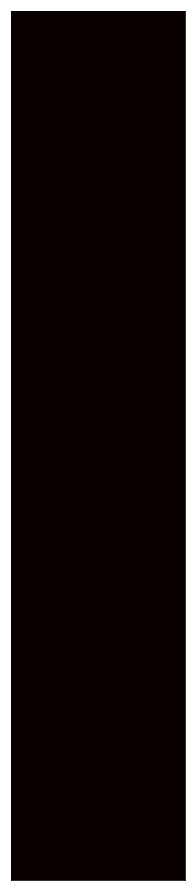

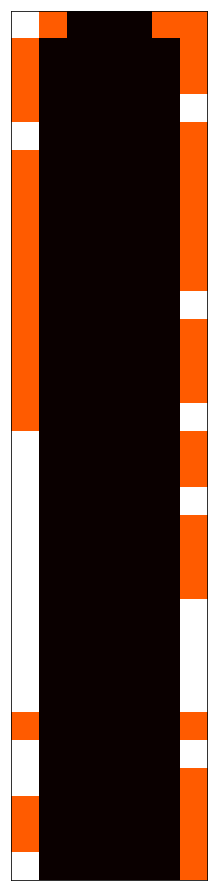

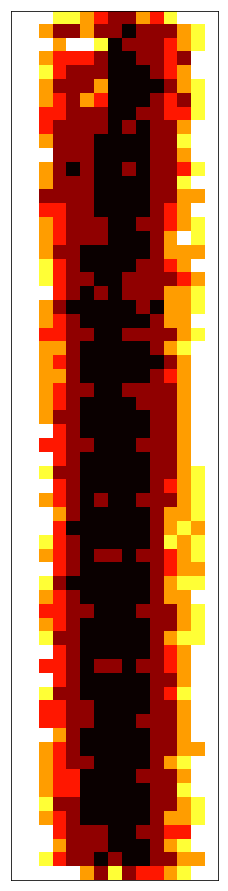

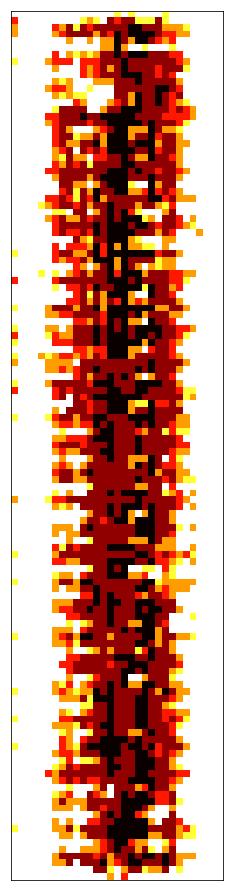

In [6]:
# choose the finest model
model = models['model_L3_4']

# resolved maps at different levels (that suggest poorly reconstructed regions)
for i in range(4):
    print(model.resolved_maps[str(i)].keys())
    
for i in range(4):
    level_maps = model.resolved_maps[str(i)]
    for key in level_maps.keys():
        if key == '0':
            intensities = (1 - level_maps[key])
        else:
            intensities += (1 - level_maps[key])
    file_name = 'L{}.png'.format(i)
    fig, ax = plt.subplots(1, 1, figsize=(4, 16))
    ax.imshow(intensities.cpu().detach().numpy(), cmap='hot')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.savefig(os.path.join(result_path, file_name))

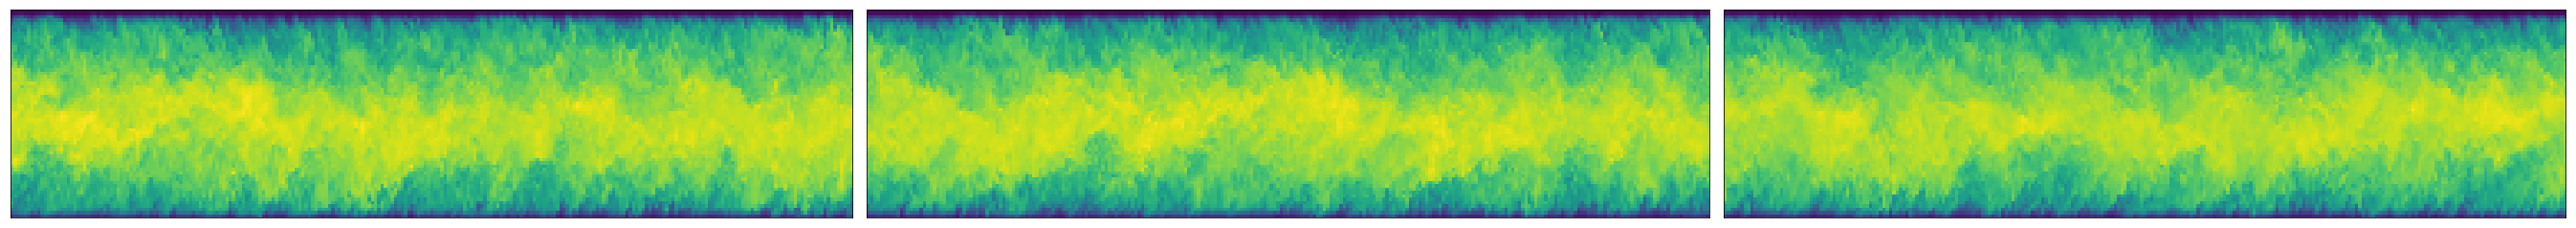

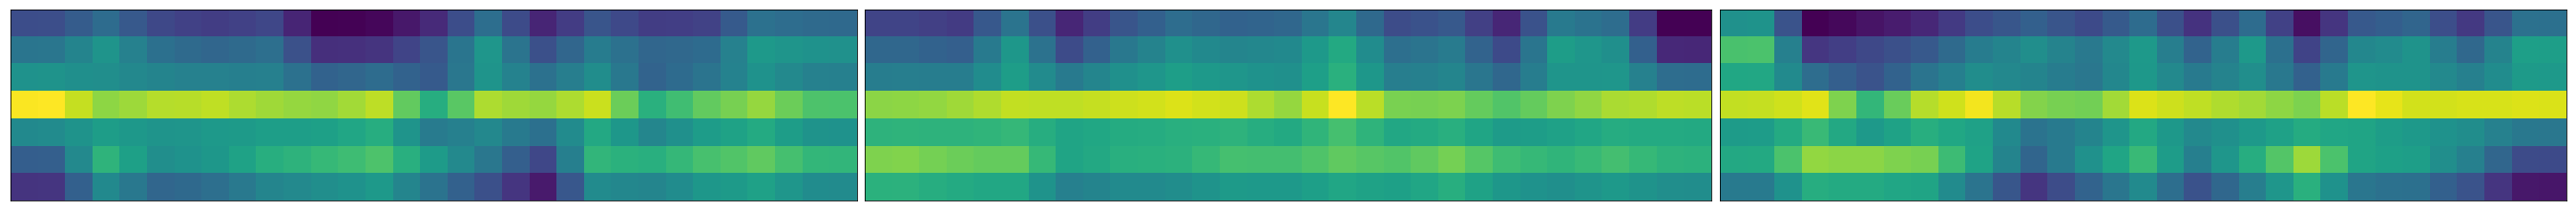

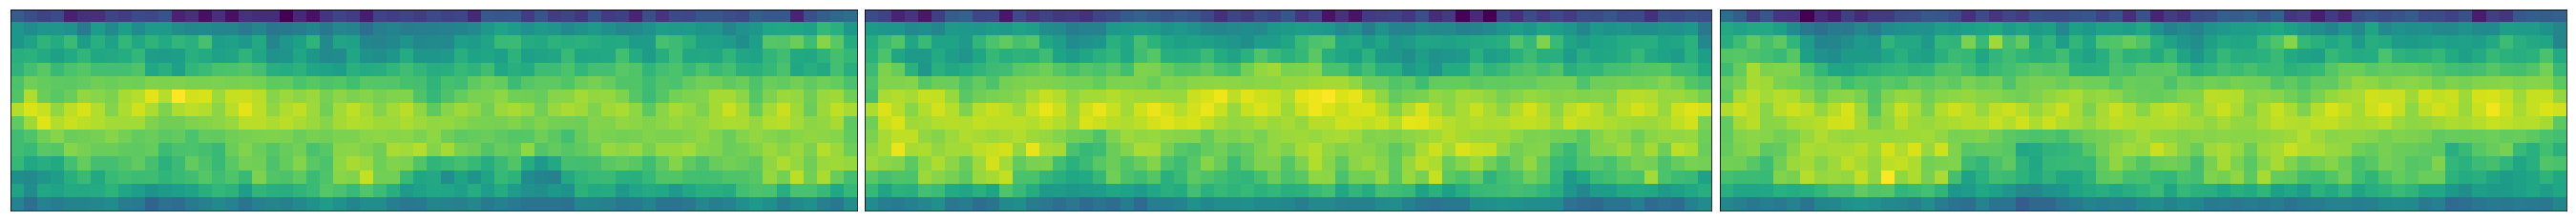

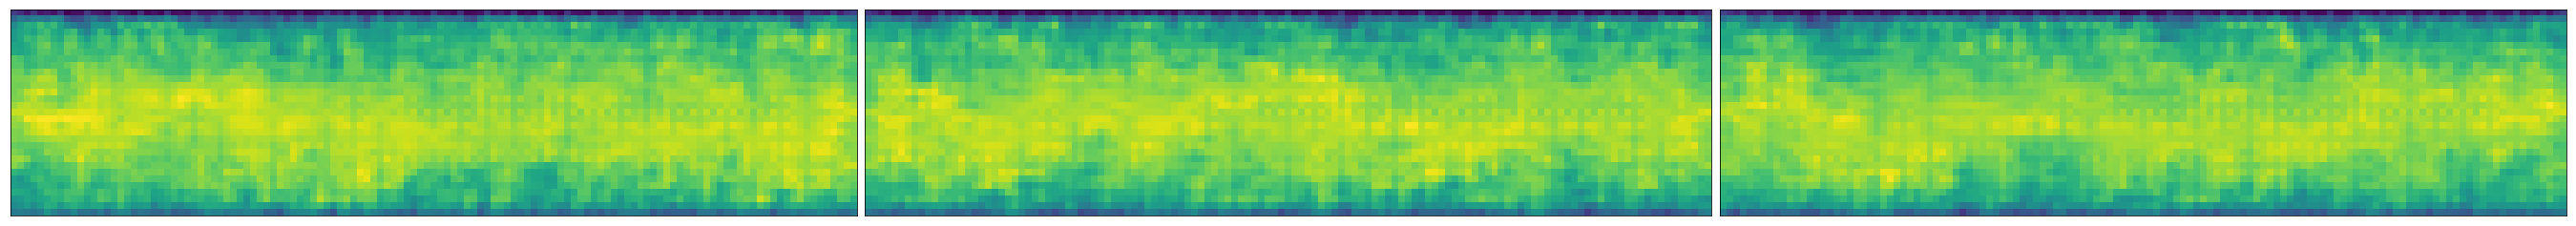

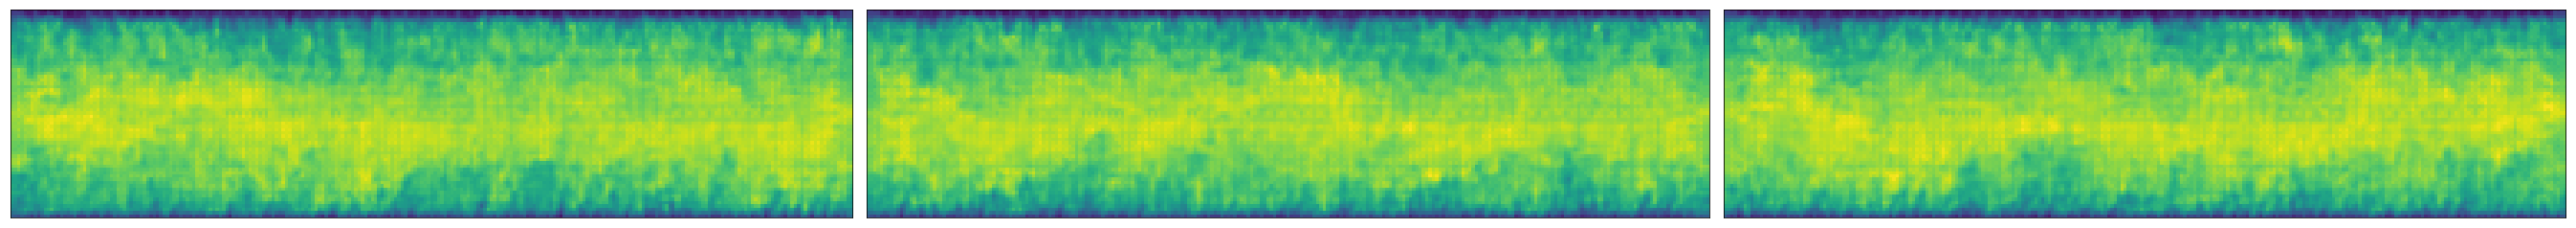

In [7]:
inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 3
n_step = n_snapshots // 3

fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*16, 4))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    axes[i].imshow(dataset.data[inds[i*n_step], :, :, :].squeeze().T.cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_samples.png'), bbox_inches='tight')


model = models['model_L0_0']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*16, 4))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=0)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().T.detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.savefig(os.path.join(result_path, 'test_L0_reconstructions.png'), bbox_inches='tight')


model = models['model_L1_3']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*16, 4))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=1)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().T.detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L1_reconstructions.png'), bbox_inches='tight')


model = models['model_L2_4']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*16, 4))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().T.detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

model = models['model_L3_4']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*16, 4))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=3)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().T.detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L3_reconstructions.png'), bbox_inches='tight')

In [8]:
records = {}
for file_name in sorted(os.listdir(result_path)):
    if file_name.endswith('.dat'):
        key, _ = file_name.split('.')
        with open(os.path.join(result_path, file_name), 'rb') as f: 
            records[key]= pickle.load(f)

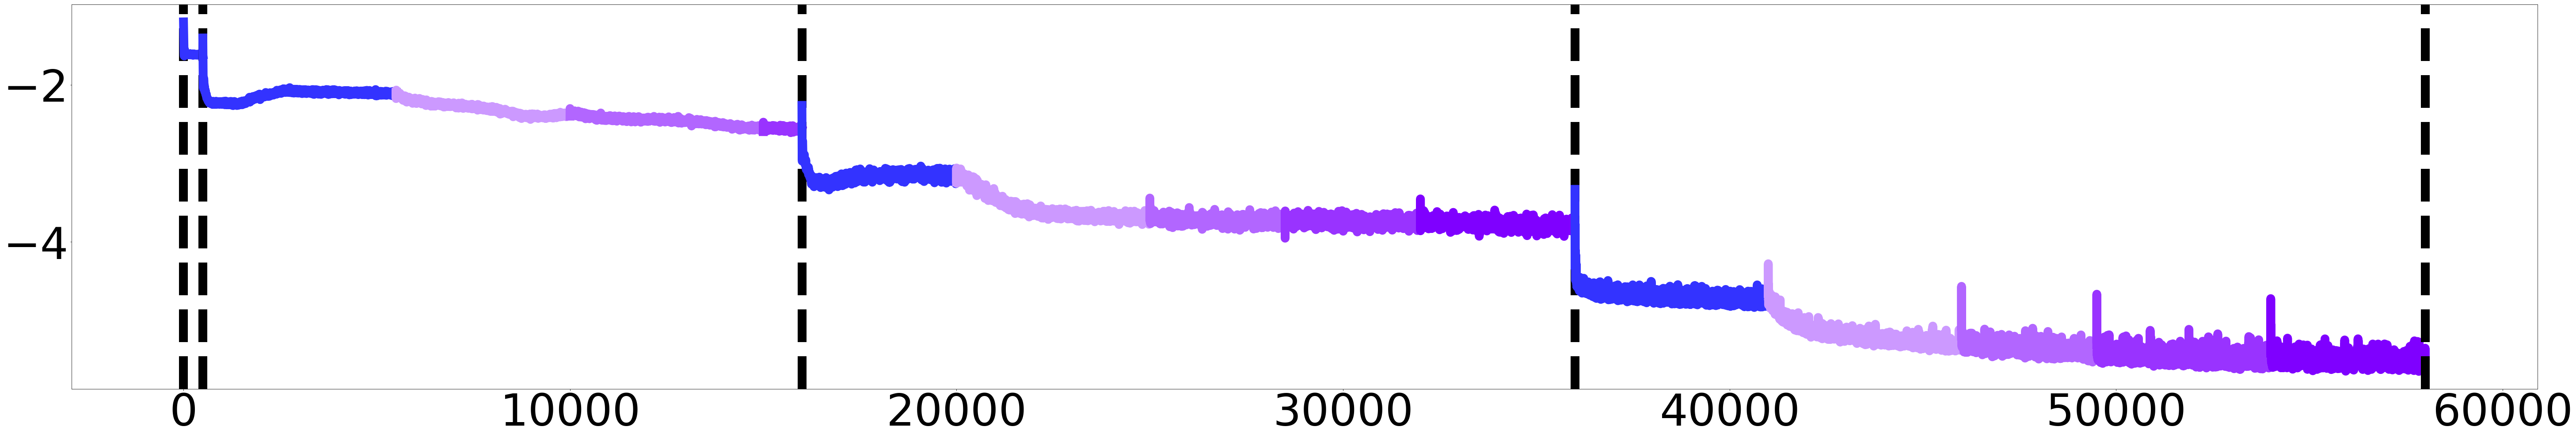

In [9]:
n_colors = 4
colors = [(51/255, 51/255, 255/255)]+ \
         [(204/255, 153/255, 255/255), 
          (178/255, 102/255, 255/255),
          (153/255, 51/255, 255/255),
          (127/255, 0/255, 255/255),
          (102/255, 0/255, 204/255),
          (76/255, 0/255, 153/255)]

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(100, 16))

# plot
s = 0
for i in range(4):
    level_errs = records['val_errs'][i]
    n_widens = len(level_errs)
    ax1.axvline(x=s, color='k', linestyle='--', linewidth=20)
    for j in range(n_widens):
        op_err = level_errs[j]
        ax1.plot(range(s, s + len(op_err)), np.log(op_err), color=colors[j], linewidth=20)
        s += len(op_err)
        
ax1.axvline(x=s-1, color='k', linestyle='--', linewidth=20)

ax1.xaxis.set_tick_params(labelsize=100)
ax1.yaxis.set_tick_params(labelsize=100)

fig1.savefig(os.path.join(result_path, 'err_iter_plot.png'))